In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/data/Bhopal.csv'
df = pd.read_csv(file_path)

Mounted at /content/drive


<ipython-input-3-5ae04a3df4e9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ghi_f['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour']])


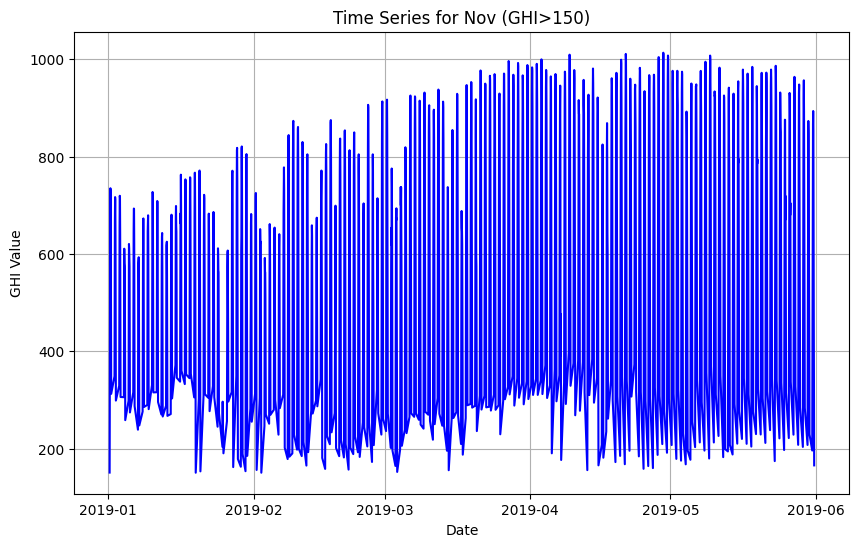

In [3]:
ghi = df[(df['Year'] == 2019) & (df['Month'] < 6)]
mask_ghi = ghi['GHI'] > 150
ghi_f = ghi[mask_ghi]

# Combine year, month, day, and hour columns into a single datetime column
ghi_f['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour']])

# Plot time series
plt.figure(figsize=(10, 6))
plt.plot(ghi_f['Date'], ghi_f['GHI'], color='blue')
plt.title('Time Series for Nov (GHI>150)')
plt.xlabel('Date')
plt.ylabel('GHI Value')
plt.grid(True)
plt.show()

In [4]:
#get dataset in the form of a 2d array with 1 column

trainset = ghi_f[['GHI']]
print(trainset.shape)

ghi2 = df[(df['Year'] == 2019) & (df['Month'] == 6)]
mask_ghi = ghi2['GHI'] > 150
ghi_f2 = ghi2[mask_ghi]

testset = ghi_f2[['GHI']]
print(testset.shape)

(1474, 1)
(321, 1)


In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

#scaling values for faster model training
scaled_train = scaler.fit_transform(trainset)
scaled_test = scaler.fit_transform(testset)

print(*scaled_train[:5])
print(*scaled_test[:5])

[0.0003475] [0.2458648] [0.45670203] [0.60710976] [0.6773039]
[0.07154508] [0.33366696] [0.58302442] [0.78992438] [0.92178233]


In [6]:
sequence_length = 30
X_train, y_train = [],[]
for i in range(len(scaled_train) - sequence_length):
  X_train.append(scaled_train[i:i+sequence_length])
  y_train.append(scaled_train[i+1:i+sequence_length+1])

X_train, y_train = np.array(X_train) , np.array(y_train)

#convert data in PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_train.shape, y_train.shape

(torch.Size([1444, 30, 1]), torch.Size([1444, 30, 1]))

In [7]:
sequence_length = 10
X_test, y_test = [],[]
for i in range(len(scaled_test) - sequence_length):
  X_test.append(scaled_test[i:i+sequence_length])
  y_test.append(scaled_test[i+1:i+sequence_length+1])

X_test, y_test = np.array(X_test) , np.array(y_test)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
X_test.shape, y_test.shape

(torch.Size([311, 10, 1]), torch.Size([311, 10, 1]))

In [8]:
class LSTMModel(nn.Module):

  def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

  def forward(self, x):
      out, _ = self.lstm(x)
      out = self.linear(out)
      return out

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [10]:
input_size = 1
num_layers = 2
hidden_size = 32
output_size = 1

# Define the model
model = LSTMModel(input_size, hidden_size, num_layers).to(device)

loss_fn = torch.nn.MSELoss(reduction='mean')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print(model)

LSTMModel(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (linear): Linear(in_features=32, out_features=1, bias=True)
)


In [11]:
batch_size = 16
# DataLoader for batch training
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [12]:
num_epochs = 60
train_hist =[]
test_hist =[]
# Training loop
for epoch in range(num_epochs):
    total_loss = 0.0

    # Training
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()


    average_loss = total_loss / len(train_loader)
    train_hist.append(average_loss)

    # Validation on test data
    model.eval()
    with torch.no_grad():
        total_test_loss = 0.0

        for batch_X_test, batch_y_test in test_loader:
            batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
            predictions_test = model(batch_X_test)
            test_loss = loss_fn(predictions_test, batch_y_test)

            total_test_loss += test_loss.item()

        # Calculate average test loss and accuracy
        average_test_loss = total_test_loss / len(test_loader)
        test_hist.append(average_test_loss)
    if (epoch+1)%10==0:
        print(f'Epoch [{epoch+1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')


Epoch [10/60] - Training Loss: 0.0045, Test Loss: 0.0110
Epoch [20/60] - Training Loss: 0.0039, Test Loss: 0.0102
Epoch [30/60] - Training Loss: 0.0036, Test Loss: 0.0097
Epoch [40/60] - Training Loss: 0.0033, Test Loss: 0.0097
Epoch [50/60] - Training Loss: 0.0032, Test Loss: 0.0095
Epoch [60/60] - Training Loss: 0.0030, Test Loss: 0.0097


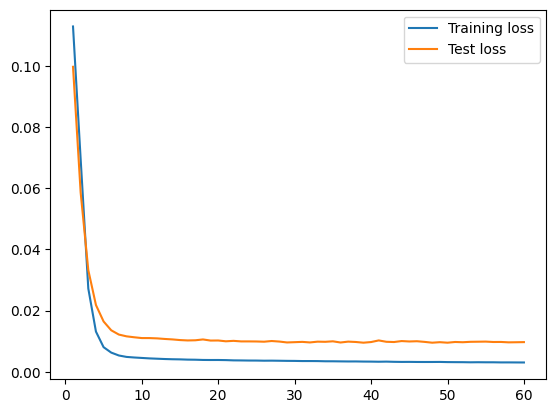

In [13]:
x = np.linspace(1,num_epochs,num_epochs)
plt.plot(x,train_hist,scalex=True, label="Training loss")
plt.plot(x, test_hist, label="Test loss")
plt.legend()
plt.show()

In [14]:
X_test.shape
sequence_to_plot = X_test.squeeze().cpu().numpy()
sequence_to_plot.shape

(311, 10)

In [16]:
# Define the number of future time steps to forecast
num_forecast_steps = 30


historical_data = scaled_test
print(historical_data.shape)
last_sequence = X_test
#historical_data = last_sequence.view(1,30,1)
#print(historical_data.shape)

forecasted_values = []

# Use the trained model to forecast future values
with torch.no_grad():
	for _ in range(num_forecast_steps*2):
		historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float().to(device)
		predicted_value = model(historical_data_tensor).cpu().numpy()[0, 0]
		forecasted_values.append(predicted_value[0])

		# Update the historical_data sequence by removing the oldest value and adding the predicted value
		historical_data = np.roll(historical_data, shift=-1)
		historical_data[-1] = predicted_value

# Generate the next dates
last_date = testset.index[-1]
last_date_datetime = pd.to_datetime(last_date, unit='D')
future_dates = pd.date_range(start=last_date_datetime + pd.DateOffset(1), periods=30)
combined_index = testset.index.append(future_dates)

(321, 1)


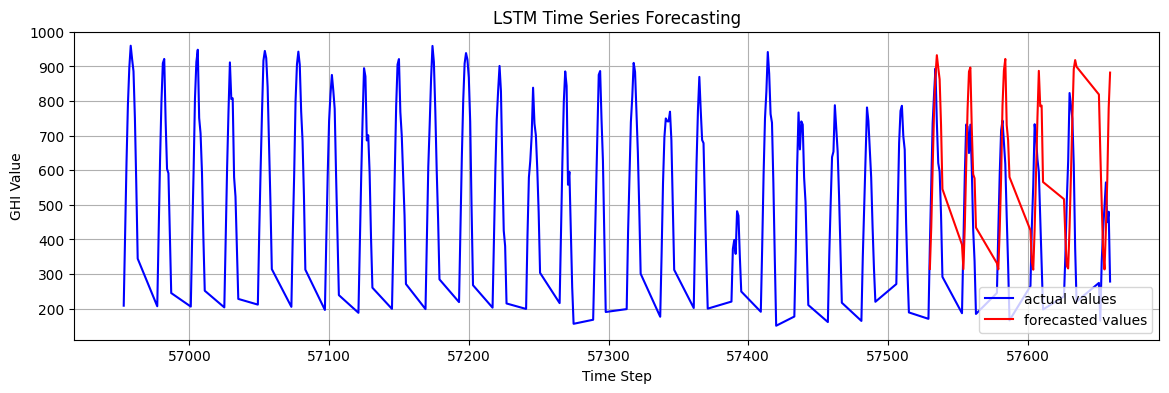

In [17]:
plt.rcParams['figure.figsize'] = [14, 4]

plt.plot(testset.index, testset.GHI, label="actual values", color="b")
original_cases = scaler.inverse_transform(scaled_test).flatten()
forecasted_cases = scaler.inverse_transform(np.expand_dims(forecasted_values, axis=0)).flatten()
plt.plot(testset.index[-60:], forecasted_cases, label='forecasted values', color='red')

plt.xlabel('Time Step')
plt.ylabel('GHI Value')
plt.legend()
plt.title('LSTM Time Series Forecasting')
plt.grid(True)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# RMSE calculation
rmse = mean_squared_error(testset.GHI[-60:], forecasted_cases[-60:], squared=False)

# MAE calculation
mae = mean_absolute_error(testset.GHI[-60:], forecasted_cases[-60:])

# MBE calculation
mbe = np.mean(testset.GHI[-60:] - forecasted_cases)

print("RMSE:", rmse)
print("MAE:", mae)
print("MBE:", mbe)


RMSE: 269.5181368783398
MAE: 224.92922867838539
MBE: -115.51684765625001


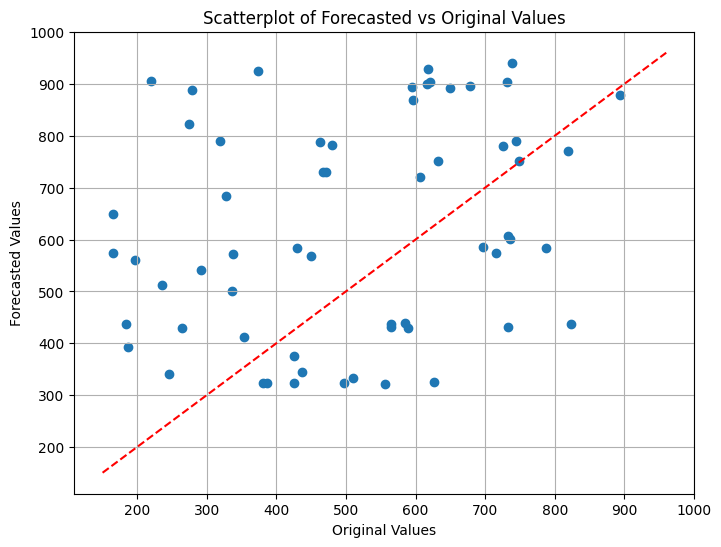

In [ ]:
# Assuming actual values are in testset.GHI and forecasted values are in forecasted_cases

plt.figure(figsize=(8, 6))
plt.scatter(testset.GHI[-60:], forecasted_cases)
plt.plot([testset.GHI.min(), testset.GHI.max()], [testset.GHI.min(), testset.GHI.max()], color='red', linestyle='--')
plt.title('Scatterplot of Forecasted vs Original Values')
plt.xlabel('Original Values')
plt.ylabel('Forecasted Values')
plt.grid(True)
plt.show()